### Importing library

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as optimization
import pandas_datareader.data as web
import datetime

### Fetching Data

In [4]:
start_date = datetime.datetime(2017, 4, 1)
end_date = datetime.datetime(2023, 3, 1)
nifty_50_symbol = '^NSEI'
nifty_50_data = yf.download(nifty_50_symbol, start=start_date, end=end_date)['Close']
# Create a DataFrame
nifty_50_df = pd.DataFrame(nifty_50_data)
nifty_50_df.to_csv("nifty_50.csv",index=True)
nifty_50 = pd.read_csv("nifty_50.csv",parse_dates=True,index_col="Date")
nifty_50

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2017-04-03,9237.849609
2017-04-05,9265.150391
2017-04-06,9261.950195
2017-04-07,9198.299805
2017-04-10,9181.450195
...,...
2023-02-22,17554.300781
2023-02-23,17511.250000
2023-02-24,17465.800781


### Plotting the data

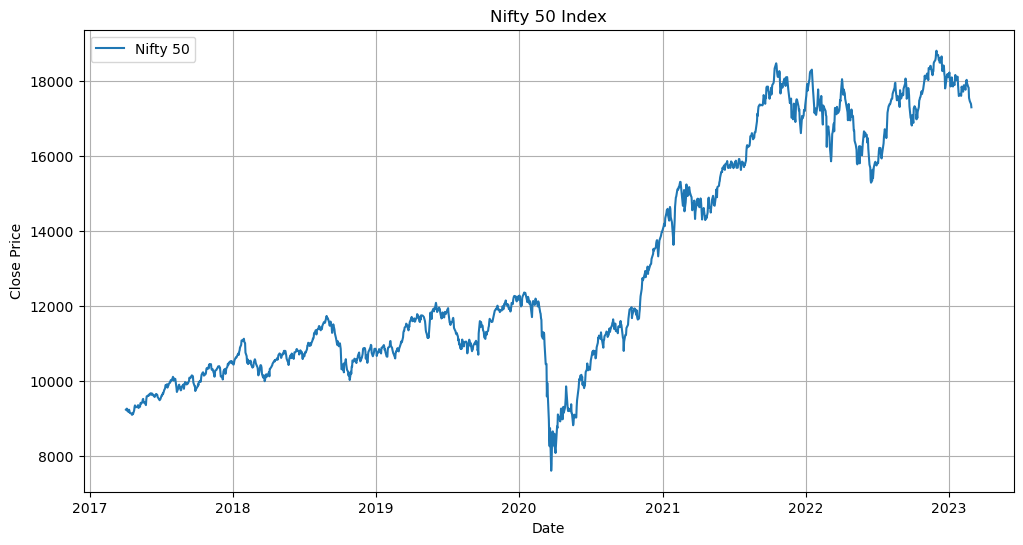

In [5]:
import matplotlib.pyplot as plt
# Plot Nifty 50 data
plt.figure(figsize=(12, 6))
plt.plot(nifty_50.index, nifty_50['Close'], label='Nifty 50')
plt.title('Nifty 50 Index')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


### Checking for stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller
# Perform ADF test
ad_fuller_result = adfuller(nifty_50['Close'])

# Extract ADF Statistic and p-value
adf_statistic = ad_fuller_result[0]
p_value = ad_fuller_result[1]

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Interpret the results
if p_value <= 0.05:
    print('p-value is less than or equal to 0.05. The data is likely stationary.')
else:
    print('p-value is greater than 0.05. The data is likely non-stationary.')







ADF Statistic: -0.8877605073616678
p-value: 0.7919763318479246
p-value is greater than 0.05. The data is likely non-stationary.


In [7]:
import numpy as np


# Compute the first-order difference
eps_diff = np.diff(nifty_50['Close'], n=1)

# Perform ADF test on the differenced series
ad_fuller_result = adfuller(eps_diff)

# Extract ADF Statistic and p-value
adf_statistic = ad_fuller_result[0]
p_value = ad_fuller_result[1]

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Interpret the results
if p_value <= 0.05:
    print('p-value is less than or equal to 0.05. The differenced data is likely stationary.')
else:
    print('p-value is greater than 0.05. The differenced data is likely non-stationary.')


ADF Statistic: -13.4892685527545
p-value: 3.1293873492088446e-25
p-value is less than or equal to 0.05. The differenced data is likely stationary.


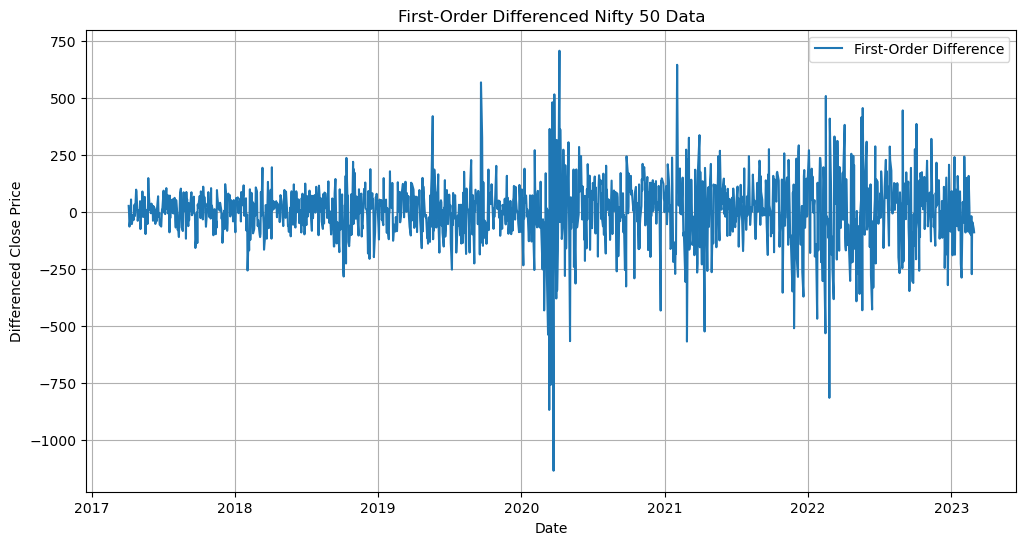

In [8]:
# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(nifty_50.index[1:], eps_diff, label='First-Order Difference')
plt.title('First-Order Differenced Nifty 50 Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.grid(True)
plt.show()


### Optimal values of parameters

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from typing import Union
from itertools import product
from tqdm import tqdm_notebook

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

# Load your time series data (replace with your own data)
# Assuming you have already loaded and prepared your data
endog_data = nifty_50_df['Close']

# Define the range of p and q values based on your requirements
ps = range(0, 6, 1)
qs = range(0, 8, 1)
d_value = 2

# Generate the list of orders to search
order_list = list(product(ps, qs))



In [38]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
train_end_date = '2022-03-01'  # Adjust this date based on your needs
train = nifty_50_df['Close'][:train_end_date]

result_df = optimize_ARIMA(train, order_list, d)
print(result_df)

  0%|          | 0/48 [00:00<?, ?it/s]

     (p,q)           AIC
0   (2, 7)  15264.633300
1   (3, 7)  15265.985585
2   (2, 5)  15266.090415
3   (4, 3)  15267.351127
4   (4, 6)  15267.942910
5   (2, 6)  15268.038889
6   (4, 4)  15268.142568
7   (4, 5)  15268.214299
8   (4, 7)  15268.322406
9   (5, 5)  15268.960961
10  (3, 6)  15269.556048
11  (5, 4)  15270.310374
12  (5, 6)  15270.349075
13  (3, 5)  15271.361937
14  (3, 4)  15271.442498
15  (2, 4)  15271.961588
16  (5, 7)  15272.071873
17  (5, 3)  15275.127271
18  (5, 2)  15276.457972
19  (1, 6)  15277.747022
20  (1, 7)  15278.050177
21  (0, 7)  15278.457763
22  (2, 3)  15279.874367
23  (5, 1)  15285.603748
24  (0, 6)  15285.782081
25  (3, 3)  15289.466611
26  (0, 1)  15297.241415
27  (0, 2)  15299.090366
28  (1, 1)  15299.100797
29  (0, 5)  15299.734890
30  (1, 5)  15299.748161
31  (0, 4)  15300.661562
32  (1, 2)  15300.819966
33  (2, 1)  15301.046395
34  (0, 3)  15301.122763
35  (3, 1)  15301.365843
36  (4, 1)  15301.956986
37  (1, 3)  15303.067391
38  (2, 2)  15303.074774


### Fitting of Model

In [39]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
model = SARIMAX(train, order=(2,2,7), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1210
Model:               SARIMAX(2, 2, 7)   Log Likelihood               -7622.317
Date:                Wed, 20 Sep 2023   AIC                          15264.633
Time:                        23:52:22   BIC                          15315.601
Sample:                             0   HQIC                         15283.826
                               - 1210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5047      0.049    -30.438      0.000      -1.602      -1.408
ar.L2         -0.8451      0.035    -24.214      0.000      -0.913      -0.777
ma.L1          0.5188      0.068      7.576      0.0

### Diagonistic Test

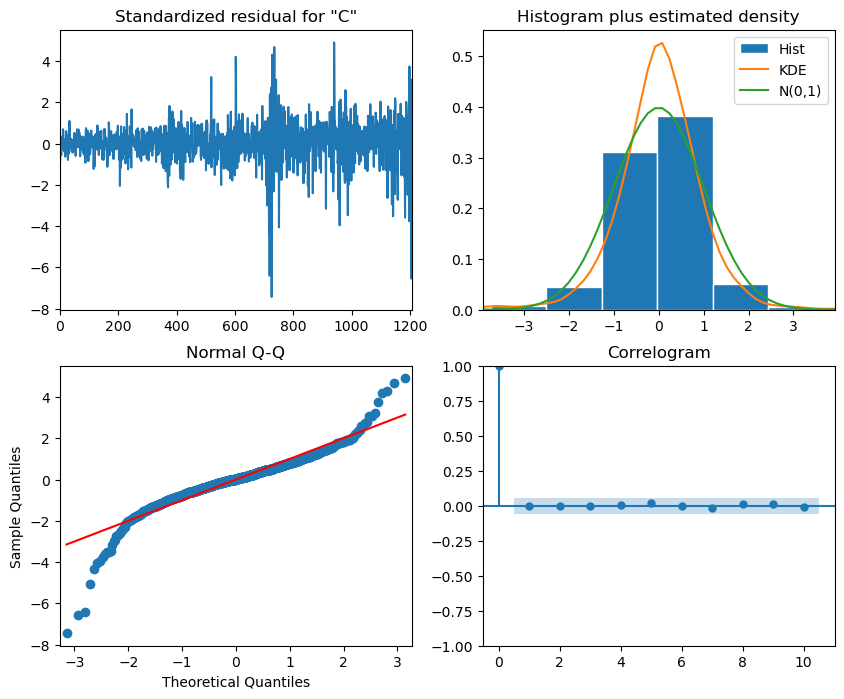

In [21]:
model_fit.plot_diagnostics(figsize=(10,8));

### Forecasting

In [36]:

# Define the number of steps to forecast (length of test data)
n_forecast = len(nifty_50_df) - len(train)

# Make predictions on the test data
SARIMAX_pred = model_fit.forecast(steps=n_forecast)

# Create a DataFrame to store the test predictions with dates
test_predictions = pd.DataFrame({'Date': nifty_50_df.index[len(train):], 'SARIMAX_pred': SARIMAX_pred})

# Display the test predictions
test_predictions


C:\Users\Rupesh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Date,SARIMAX_pred
1210,2022-03-02,16897.159677
1211,2022-03-03,16804.096866
1212,2022-03-04,16763.857503
1213,2022-03-07,16898.812995
1214,2022-03-08,16806.351692
...,...,...
1454,2023-02-22,18385.614927
1455,2023-02-23,18392.022820
1456,2023-02-24,18398.430713
1457,2023-02-27,18404.838606


### Plotting

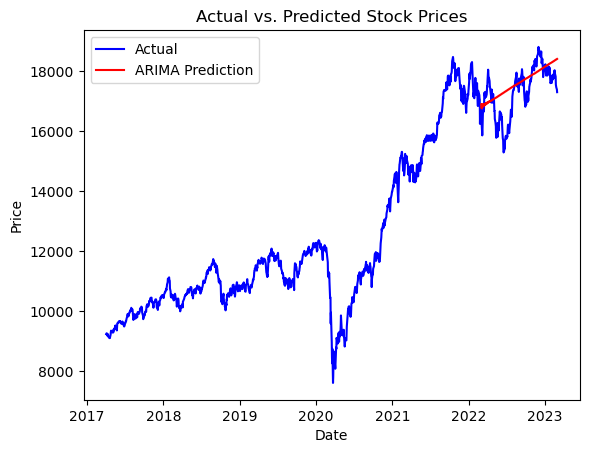

In [37]:
import matplotlib.pyplot as plt



# Plot actual data
plt.plot(nifty_50.index, nifty_50['Close'], label='Actual', color='blue')

# Plot predictions
plt.plot(test_predictions['Date'], test_predictions['SARIMAX_pred'], label='ARIMA Prediction', color='red')
# You can replace 'SARIMAX Prediction' with 'ARIMA Prediction' if you are using ARIMA

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Stock Prices')

# Add a legend
plt.legend()

# Show the plot
plt.show()


#### Arima is not giving good prediction of stock prices